In [1]:
# %%
'''
 # @ Author: Baptiste Royer
 # @ Create Time: 2022-05-25 17:40:11
 # @ Modified by: Baptiste Royer
 # @ Modified time: 2023-02-28 15:00:17
 # @ Description:
 '''

# %load_ext autoreload
# %autoreload 1
from qutip import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm
from copy import copy
from scipy.optimize import minimize
from scipy import stats
π = np.pi

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

### Define  operators

In [2]:
#%%% cavity operators
Ncav = 100
a = destroy(Ncav)
ad = dag(a)
n = ad*a
idCav = qeye(Ncav)

#%%% qubit operators
id2 = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = destroy(2)
sp = dag(sm)
Pg = (id2 + sz)/2
Pe = (id2 - sz)/2
pState = (basis(2) + basis(2,1)).unit()

In [3]:
# Symmetric controlled diplacements
def CD(alpha):
    return tensor(Pg,displace(Ncav,alpha/2)) + tensor(Pe,displace(Ncav,-alpha/2))

# Qubit rotation around Z
def Rz(phi):
    return tensor((-1j/2*phi*sz).expm(),idCav)

# Qubit rotation around Y (instead of Hadamard)
def Ry(theta):
    return tensor((-1j/2*theta*sy).expm(),idCav)

Rypi2 = Ry(-π/2) # Y -pi/2 rotation

### Series of functions useful for computing the optimal phases

In [4]:
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1,1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

def oddPowerset(s):
    res = []
    for x in powerset(s):
        if len(x)%2==1:
            res.append(x)
    return res
    # return np.where([x if len(x)%2==1 else None for x in powerset(s)] != None)

def sum1(le):
    res = []
    for x in range(1 << le):
        binx = np.binary_repr(x,width=le)
        if (sum([eval(i) for i in list(binx)]))==(le+1)/2:
            res.append([eval(i) for i in list(binx)])
    return res

# Function to compute the optimal qubit rotation phae (measurement angle)
def computePhase(phaseArr,resArray):
    if len(phaseArr)==0:
        return 0
    effPhaseArr = [phaseArr[i] + np.pi*resArray[i] for i in range(len(phaseArr))]

    oddPS = oddPowerset(np.arange(len(effPhaseArr)+1))

    # Compute (minus) sharpness, which needs to be maximized (below we use the scipy minimize function, hence the minus sign).
    def sharpness(phi):
        effPhaseArr1 = copy(effPhaseArr)
        effPhaseArr1.append(phi)
        effPhaseArr2 = copy(effPhaseArr)
        effPhaseArr2.append(phi+np.pi)
        number1 = 0
        number2 = 0
        for ops in oddPS:
            for es in sum1(len(ops)):
                phase1 = 0
                phase2 = 0
                for i in range(len(ops)):
                    phase1 += (-1)**(es[i])*effPhaseArr1[ops[i]]
                    phase2 += (-1)**(es[i])*effPhaseArr2[ops[i]]
                number1 += np.exp(1j*phase1)/2**len(ops)
                number2 += np.exp(1j*phase2)/2**len(ops)
        return -(np.abs(number1) + np.abs(number2))
    
    res = minimize(sharpness, [0.1])
    return res.x[0]

# Compute the best estimate of the phase with a set of measurement results and measurement angles
def phaseEstimate(phaseArr,resArray):

    effPhaseArr = [phaseArr[i] + np.pi*resArray[i] for i in range(len(phaseArr))]

    oddPS = oddPowerset(np.arange(len(effPhaseArr)))

    number = 0
    for ops in oddPS:
        for es in sum1(len(ops)):
            phase = 0
            for i in range(len(ops)):
                phase += (-1)**(es[i])*effPhaseArr[ops[i]]
            number += np.exp(1j*phase)/2**len(ops)
    return np.angle(number)

### Single trajectory test

Test with vacuum state

In [5]:
psi = basis(Ncav)   

Measuring limit =  6.283185307179586
[0, 1.5708022540641857, -0.7853861510474393, -1.3405275115060777, -0.9885680593116818, -1.2999878229323936, -1.076797710508406, -1.2973150505843976]
[0, 0, 0, 1, 0, 1, 0, 0]
-0.1954648486080892


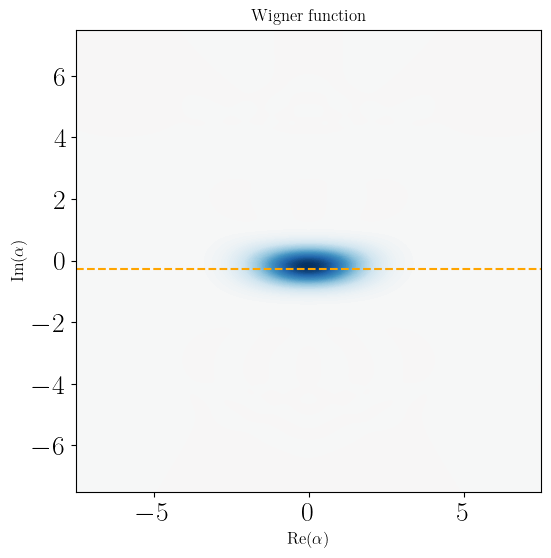

In [6]:
epsilon = 0.5
CDespilon = CD(epsilon)
Nmeas = 8 # few measurements because the optimization is too slow otherwise. 

measRecord = []
phaseArray = []
print("Measuring limit = ", np.pi/epsilon)

for i in range(Nmeas):
    psic = tensor(pState,psi)       
    psic = CDespilon*psic
    phiQb = computePhase(phaseArray,measRecord)         # Compute the optimal measurement angle for the current step
    psic = Rz(phiQb)*psic                               # Apply rotation
    psic = Rypi2*psic
    probg = expect(tensor(Pg,idCav),psic)
    if np.random.rand() < probg:
        meas = 0
        psi = tensor(basis(2).dag(),idCav)*psic
        psi = psi.unit()
    else:
        meas = 1
        psi = tensor(basis(2,1).dag(),idCav)*psic
        psi = psi.unit()

    phaseArray.append(phiQb)
    measRecord.append(meas)

print(phaseArray)
print(measRecord)
print(phaseEstimate(phaseArray,measRecord))

# %%
estimate = np.sqrt(2)/epsilon*phaseEstimate(phaseArray,measRecord)
plot_wigner(psi)
plt.plot([-7.5,7.5],np.full(2,estimate/2),'--',c='orange');

### Multiple trajectories

In [7]:
epsilon = 0.5
CDespilon = CD(epsilon)
Nmeas = 8
Ntraj = 500
trajEstimates = []

print("Measuring limit = ", np.pi/epsilon)

for j in tqdm(range(Ntraj)):
    psi = basis(Ncav)
    phaseArray = []
    measRecord = []

    for i in range(Nmeas):
        psic = tensor(pState,psi)
        psic = CDespilon*psic
        phiQb = computePhase(phaseArray,measRecord)
        psic = Rz(phiQb)*psic
        psic = Rypi2*psic
        probg = expect(tensor(Pg,idCav),psic)
        if np.random.rand() < probg:
            meas = 0
            psi = tensor(basis(2).dag(),idCav)*psic
            psi = psi.unit()
        else:
            meas = 1
            psi = tensor(basis(2,1).dag(),idCav)*psic
            psi = psi.unit()
        phaseArray.append(phiQb)
        measRecord.append(meas)

    trajEstimates.append(phaseEstimate(phaseArray,measRecord)/epsilon/np.sqrt(2))

Measuring limit =  6.283185307179586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [23:02<00:00,  2.76s/it]


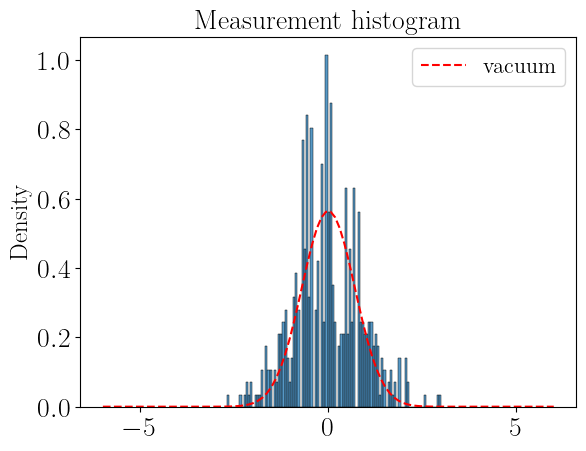

In [8]:
fig, ax = plt.subplots()
sns.histplot(data=(np.array(trajEstimates)),ax=ax,kde=False,stat="density",bins=100)
x = np.linspace(-6,6,100)
ax.plot(x, np.abs(np.exp(-x**2/2)*(1/π)**(1/4))**2, 'r--', label='vacuum') # vacuum
ax.set_title('Measurement histogram')
plt.legend();

In [10]:
# Note that the distribution for momentum in vacuum should be a gaussian with sigma = 1/sqrt(2).
# For code simplicity I multiply the estimates by sqrt(2) to compare to a gaussian with sigma = 1
stats.kstest((np.array(trajEstimates)*np.sqrt(2)), "norm")[0]

0.10045667220234406